In [2]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

from magic_land import plot_confusion_matrix

import itertools
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook
plt.rcParams["figure.figsize"] = [12,6.75]

In [3]:
df = pd.read_csv('new-thyroid.data')
df['y'] = df['y'] - 1

In [4]:
df.describe()

,y,T3-resin,Thyroxin,T3,TSH,DiffTSH
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.441860,109.595349,9.804651,2.050233,2.880000,4.199070
std,0.726737,13.145447,4.697362,1.419486,6.118031,8.070519
min,0.000000,65.000000,0.500000,0.200000,0.100000,-0.700000
25%,0.000000,103.000000,7.100000,1.350000,1.000000,0.550000
50%,0.000000,110.000000,9.200000,1.700000,1.300000,2.000000
75%,1.000000,117.500000,11.300000,2.200000,1.700000,4.100000
max,2.000000,144.000000,25.300000,10.000000,56.400000,56.300000


In [5]:
# classes distribution
df['y'].value_counts()

0    150
1     35
2     30
Name: y, dtype: int64

In [6]:
# split data into training and test
X = df.drop('y', axis=1).as_matrix()
y = df['y'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.6, random_state=12345, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, train_size=0.5, random_state=12345, stratify=y_test)

C:\Users\mg9826\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
# standardization of data
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_val = std_scaler.transform(X_val)
X_test = std_scaler.transform(X_test)

PCA was used to make visualization easier otherwise there is no need for it.

In [8]:
# PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

<IPython.core.display.Javascript object>


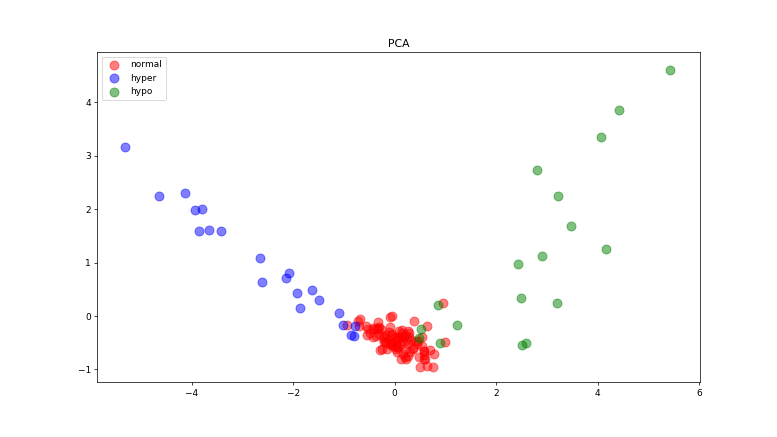

In [9]:
# visualization of training data
plt.figure()
for i, (yy, cc) in enumerate(zip(['normal', 'hyper', 'hypo'], ['r', 'b', 'g'])):
    plt.scatter(X_train_pca[y_train == i, 0],X_train_pca[y_train == i, 1], 
                c=cc, alpha=0.5, label=yy, s=100)

plt.title('PCA')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


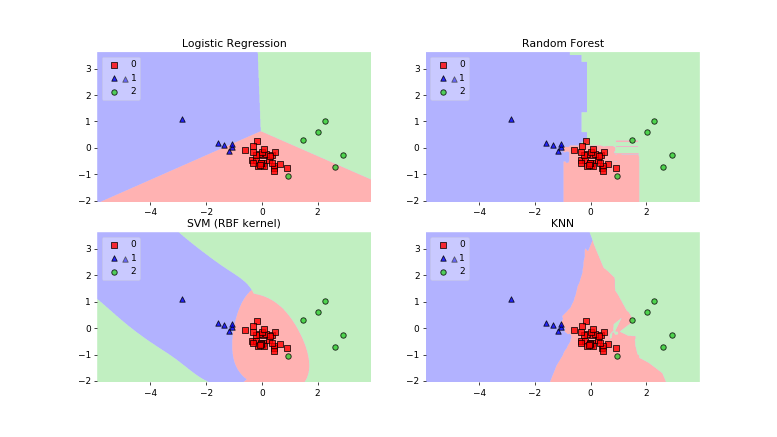

Logistic Regression accuracy: 0.8837209302325582
Random Forest accuracy: 0.9534883720930233
SVM (RBF kernel) accuracy: 0.9767441860465116
KNN accuracy: 0.9302325581395349


In [10]:
# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(kernel='rbf', random_state=0, probability=True)
clf4 = KNeighborsClassifier()

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
plt.figure()

for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         ['Logistic Regression', 'Random Forest',
                             'SVM (RBF kernel)', 'KNN'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X_train_pca, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_val_pca, y=y_val, clf=clf, legend=2)
    plt.title(lab)
    print(f'{lab} accuracy: {accuracy_score(y_val, clf.predict(X_val_pca))}')
plt.show()

Without tuning of parameters, SVM seems like the best choice!  
Let's cross-validate it and see if I just got lucky.

<IPython.core.display.Javascript object>


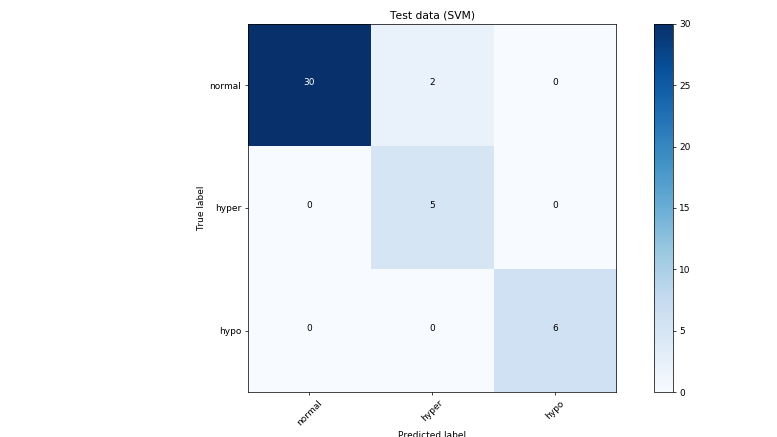

Confusion matrix, without normalization
[[30  2  0]
 [ 0  5  0]
 [ 0  0  6]]
Accuracy: 0.9534883720930233


In [11]:
plt.figure()
y_pred_test = clf3.predict(X_test_pca)
conf_mat = confusion_matrix(y_pred_test,y_test)
plot_confusion_matrix(conf_mat, normalize=False, 
                      classes=['normal','hyper','hypo'], title='Test data (SVM)')
plt.show()
print(f'Accuracy: {accuracy_score(y_pred_test, y_test)}')

<IPython.core.display.Javascript object>


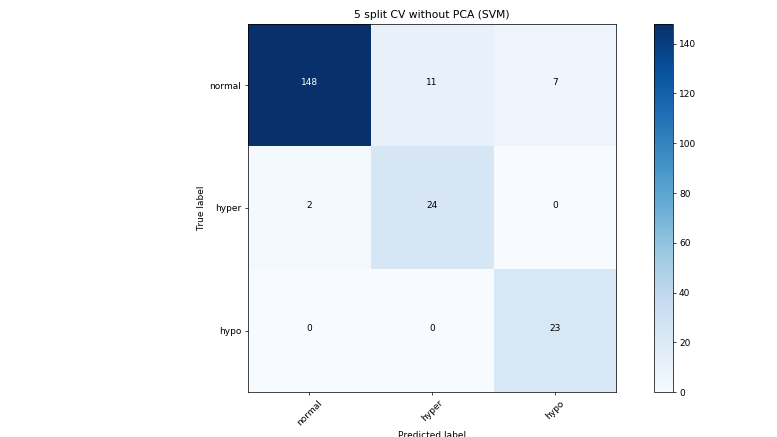

Confusion matrix, without normalization
[[148  11   7]
 [  2  24   0]
 [  0   0  23]]
Accuracy: 0.9069767441860465


In [12]:
# model without PCA using 5-fold stratified cross-validation
y_pred = np.empty(len(X))
plt.figure()

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    # split into test and train
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # standardize
    std_scaler = StandardScaler()
    std_scaler.fit(X_train)
    X_train = std_scaler.transform(X_train)
    X_test = std_scaler.transform(X_test)
    
    # model
    clf3 = SVC(kernel='rbf', random_state=0, probability=True)
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict(X_test)
    
conf_mat = confusion_matrix(y_pred,y)
plot_confusion_matrix(conf_mat, normalize=False, 
                      classes=['normal','hyper','hypo'], title='5 split CV without PCA (SVM)')
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y)}')

Further consideration: It might be useful to adapt probability treesholds because ussually it's better to classify healthy adult as sick than the way around.   